# Introduction

## About

Image classifier that recognizes different Brazilian Jiu Jitsu grappling positions and predicts future outcomes! Uses a sequential neural network trained on a dataset of mounts/guards/submissions/areas of control to label the most resembled situation and a decision tree map to return the k-closest neighbours

## Editorial

```
V1: Multi-class classifier without decision tree algorithm, trained on: armbar, arm triangle, double-leg, guillotine, koshi guruma, leg triangle, rnc

    Notes:
    - Best result: 96% training acc, 65% validation acc
    - Need to: optimize regularization techniques to work effectively (not underfit)
    - May need more data and a more complex model
```

## Flow Chart

This flow chart/decision tree maps different submissions/escapes/passes and takedowns according to the starting position. The highlighted colours give a rough idea of the quality of respective data per query on the top 100 google images. Additional images were added from varying UFC video games to provide more data.

```
Dark grey: very poor,
Grey: poor,
Light grey: average,
Green: good,
Blue: very good
```

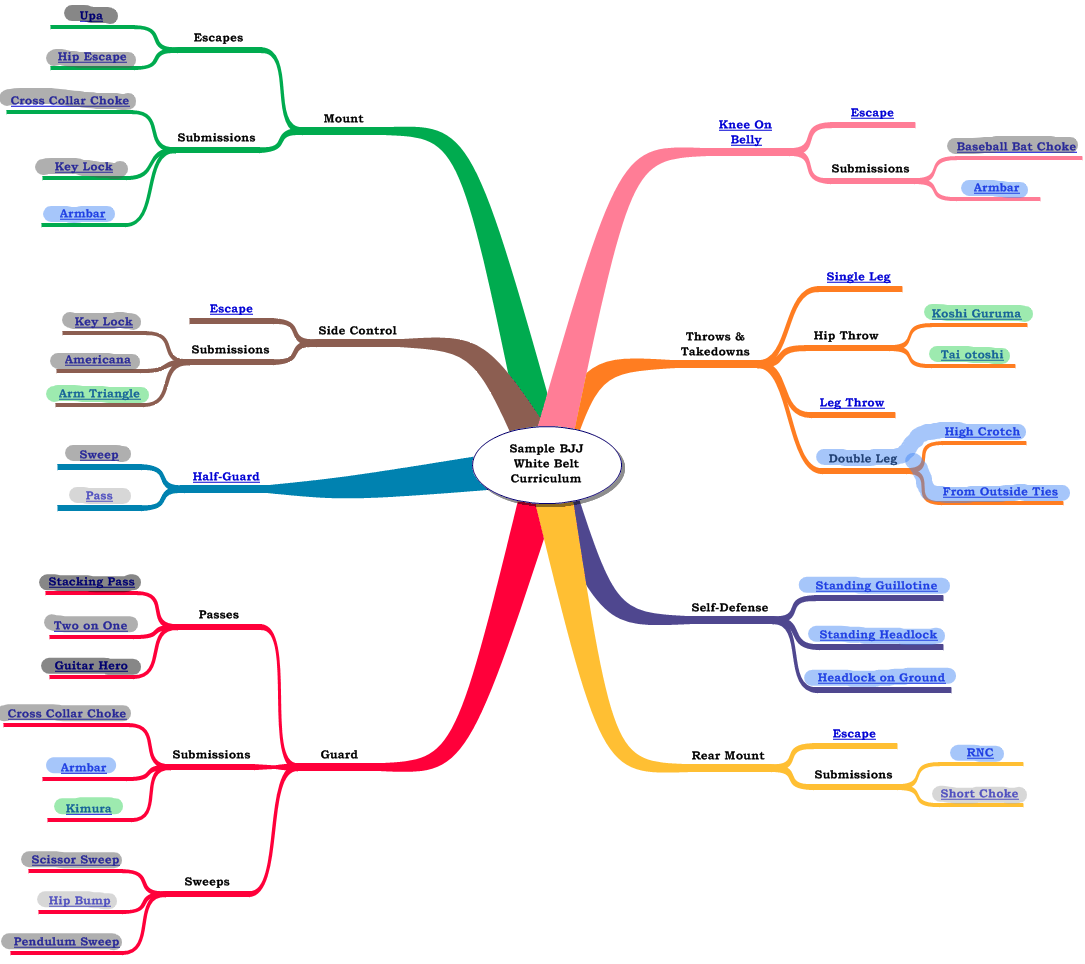

## 1. Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install keras

In [ ]:
!pip list

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

## 2. Configure Setup

In [2]:
# # *** This only works natively with NVIDIA gpus
# Avoid Out of Memory errors by enabling VRAM consumption growth
# gpu = tf.config.experimental.list_physical_devices('gpu')
# tf.config.experimental.set_memory_growth(gpu, True)

## 3. Import Data

#### Remove unwanted images

In [3]:
data_dir = "../JiuJitsuAI/Data"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

#### Display a mock batch of images

In [4]:
images = tf.keras.utils.image_dataset_from_directory('../JiuJitsuAI/Data')

Found 1444 files belonging to 7 classes.


In [10]:
image_iterator = images.as_numpy_iterator()

In [11]:
batch = image_iterator.next()

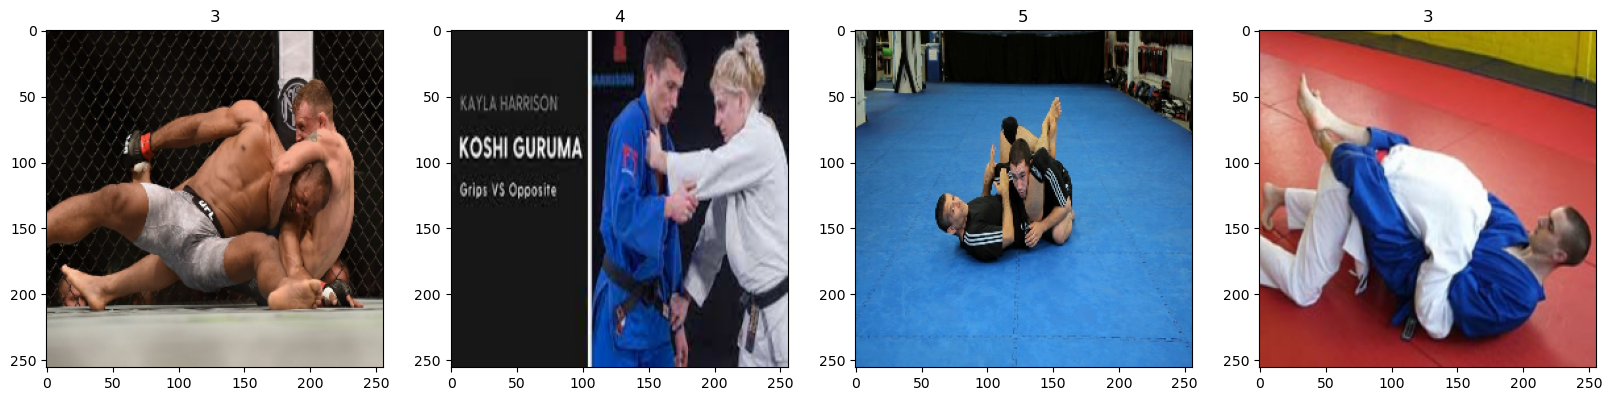

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int), cmap='gray', vmin=0, vmax=1)
  ax[idx].title.set_text(batch[1][idx])

## 4. Preprocess Data

In [14]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset='training'
)
data = data.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 1011 files for training.


In [15]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
val = val.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 288 files for validation.


In [16]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)
test = test.map(lambda x, y: (x / 255.0, y))

Found 1444 files belonging to 7 classes.
Using 144 files for validation.


## 5. Build Model

In [17]:
model = Sequential()

In [18]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [19]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 6. Train Model

In [21]:
logdir = '../JiuJitsuAI/Logs'

In [22]:
#Log out model training as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
#Data, how long you will train for, after all training batches are run validation data is used, additional callbacks
history = model.fit(
    data,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
32/32 [==============================] - 36s 1s/step - loss: 0.4566 - accuracy: 0.1751 - val_loss: 0.4002 - val_accuracy: 0.2569
Epoch 2/20
32/32 [==============================] - 30s 912ms/step - loss: 0.3800 - accuracy: 0.3076 - val_loss: 0.3784 - val_accuracy: 0.3021
Epoch 3/20
32/32 [==============================] - 30s 922ms/step - loss: 0.3275 - accuracy: 0.4738 - val_loss: 0.3600 - val_accuracy: 0.4132
Epoch 4/20
32/32 [==============================] - 30s 929ms/step - loss: 0.2357 - accuracy: 0.6795 - val_loss: 0.3424 - val_accuracy: 0.4792
Epoch 5/20
32/32 [==============================] - 29s 877ms/step - loss: 0.1494 - accuracy: 0.8299 - val_loss: 0.3641 - val_accuracy: 0.5347
Epoch 6/20
32/32 [==============================] - 30s 904ms/step - loss: 0.0891 - accuracy: 0.9228 - val_loss: 0.4083 - val_accuracy: 0.5139
Epoch 7/20
32/32 [==============================] - 31s 959ms/step - loss: 0.0561 - accuracy: 0.9525 - val_loss: 0.4621 - val_accuracy: 0.5382
Ep

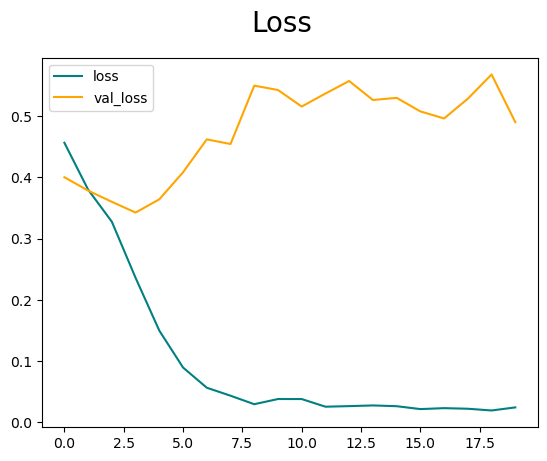

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

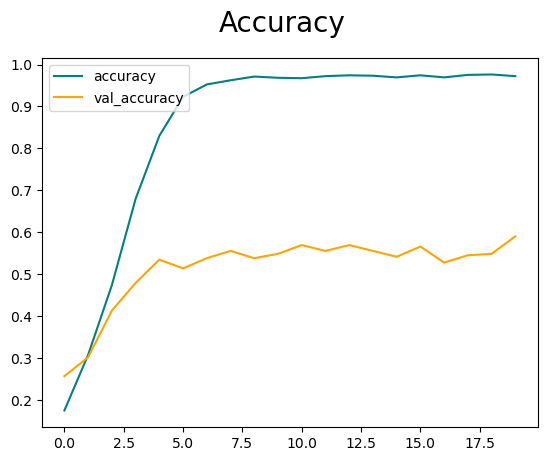

In [26]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 7. Evaluate Model

In [27]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [29]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 222ms/step


In [30]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.633093535900116, Recall: 0.6111111044883728, Accuracy: 0.8938491940498352


# 8. Test on some images!

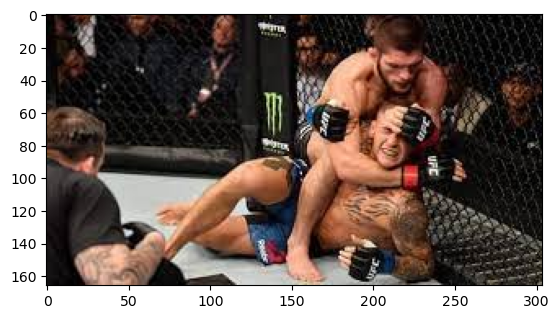

In [41]:
img = cv2.imread('../JiuJitsuAI/Data/RearNakedChoke/image5.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
resize = tf.image.resize(img, (256, 256))
np.expand_dims(resize, 0)

array([[[[  4.90625  ,   1.09375  ,  13.09375  ],
         [  4.28125  ,   2.5625   ,  14.       ],
         [  2.65625  ,   2.125    ,  10.25     ],
         ...,
         [  7.03125  ,   7.03125  ,   7.03125  ],
         [ 11.5      ,  11.5      ,  11.5      ],
         [ 15.09375  ,  15.09375  ,  15.09375  ]],

        [[  6.7525635,   2.984375 ,  14.467407 ],
         [  5.6992188,   4.3201904,  15.078247 ],
         [  3.409546 ,   2.878296 ,  11.446411 ],
         ...,
         [  5.8200684,   5.8200684,   5.8200684],
         [  8.6345215,   8.6345215,   8.6345215],
         [ 39.49463  ,  39.49463  ,  39.49463  ]],

        [[  9.164429 ,   5.6765137,  15.988647 ],
         [  7.5234375,   6.6445312,  16.160156 ],
         [  4.435425 ,   4.138794 ,  12.94397  ],
         ...,
         [  4.0562744,   4.0562744,   4.0562744],
         [  5.02124  ,   5.02124  ,   5.02124  ],
         [ 66.45386  ,  66.45386  ,  66.45386  ]],

        ...,

        [[ 16.796509 ,  15.796509 ,  1

In [43]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 59ms/step


In [44]:
yhat

array([[2.1036518e-11, 6.8764798e-09, 3.1183916e-07, 4.9659992e-08,
        2.5167249e-10, 1.9258887e-07, 9.9999940e-01]], dtype=float32)

In [52]:
classes = ['Armbar', 'Arm Triangle', 'Double Leg', 'Guillotine', 'Koshi Guruma', 'Leg Triangle', 'Rear Naked Choke']
for index, label in enumerate(yhat[0]):
    print(classes[index] + ': ', label*100)

Armbar:  2.10365180136618e-09
Arm Triangle:  6.876479829998061e-07
Double Leg:  3.1183915893961967e-05
Guillotine:  4.965999167438895e-06
Koshi Guruma:  2.516724884049637e-08
Leg Triangle:  1.9258887107298506e-05
Rear Naked Choke:  99.99994039535522
